In [ ]:
!pip install darts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_for = 500
predict_for = 14

In [ ]:
from darts.models import TCNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
print(df.columns)
print(df.state_residence.unique())
df.head()

Index(['Unnamed: 0', 'state_residence', 'district_residence', 'Date', '<15',
       '15-24', '25-34', '35-44', '45-59', '60-80', '>80', '<15_pos',
       '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos',
       '>80_pos', 'M_pos', '2', 'F_pos', 'T', 'F', 'M', 'NIA', 'T_pos',
       'NIA_pos', 'O', 'O_pos', 'N', 'G', ',', 'D', 'new_case',
       'negative_case', 'Failed_test', 'Total_test',
       'negative_egene_screening', 'positive_egene_screening',
       'Failed_test_egene_screening', '<20_ct_value_screening',
       '20-30_ct_value_screening', '31-35_ct_value_screening',
       '>35_ct_value_screening', '<20_posct_value_screening',
       '20-30_posct_value_screening', '31-35_posct_value_screening',
       '>35_posct_value_screening', 'negative_rdrp_confirmatory',
       'positive_rdrp_confirmatory', 'Failed_test_rdrp_confirmatory',
       '<20_ct_value_rdrp', '20-30_ct_value_rdrp', '31-35_ct_value_rdrp',
       '>35_ct_value_rdrp', '<20_posct_value_rdrp', '20-30_po

,Unnamed: 0,state_residence,district_residence,Date,<15,15-24,25-34,35-44,45-59,60-80,...,V,1,4,6,9,.,B,-,`,Q
0,287749,kerala,ALAPPUZHA,2019-12-01,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,650410,uttar pradesh,LUCKNOW,2019-12-03,0.0,0.0,2.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,606988,uttar pradesh,AURAIYA,2019-12-06,2.0,0.0,3.0,3.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,650411,uttar pradesh,LUCKNOW,2019-12-13,2.0,0.0,9.0,3.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6707,andhra pradesh,KRISHNA,2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df=df.groupby(['Date']).agg({'<15_pos': 'sum', '15-24_pos': 'sum', '25-34_pos':'sum', '35-44_pos':'sum', '45-59_pos':'sum', '60-80_pos':'sum', '>80_pos':'sum', 'new_case': 'sum'}).reset_index()
df.head()


date = df.iloc[train_for + 1]['Date']

In [ ]:
class Model:
  def __init__(self, df, epochs = 100):
    self.df = df
    self.epochs = epochs
    self.window_size= 50  # we can also find the back lookback period
    self.output_length = 1
    self.kernel_size = 3
    # self.df = smoothen(self.df, 5)
    self.series = TimeSeries.from_values(self.df)
    self.train_scaler = Scaler()
    self.scaled_train = self.train_scaler.fit_transform(self.series)

    

    # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
    # a period of 5 epochs (`patience`)
    my_stopper = EarlyStopping(
        monitor="train_loss",
        patience=7,
        min_delta=0.00000001,
        mode='min',
    )

    pl_trainer_kwargs={"callbacks": [my_stopper]}


    self.model = TCNModel(
      input_chunk_length = self.window_size,
      output_chunk_length = self.output_length,
      pl_trainer_kwargs = pl_trainer_kwargs,
      kernel_size = self.kernel_size,
      dropout=0.5
  )

  def fit(self):
    self.model.fit(
      self.scaled_train,
      epochs=self.epochs)
  
  def predict(self, predict_for):
    scaled_pred = self.model.predict(n=predict_for)
    pred = self.train_scaler.inverse_transform(scaled_pred)

    return pred

In [ ]:
# class Model:
#   def __init__(self, df, epochs = 100):
#     self.df = df
#     self.epochs = epochs
#     self.window_size= 50  # we can also find the back lookback period
#     self.output_length = 1
#     self.kernel_size = 4
#     # self.df = smoothen(self.df, 10)
#     self.series = TimeSeries.from_values(self.df)
#     self.train_scaler = Scaler()
#     self.scaled_train = self.train_scaler.fit_transform(self.series)

    

#     # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
#     # a period of 5 epochs (`patience`)
#     my_stopper = EarlyStopping(
#         monitor="train_loss",
#         patience=7,
#         min_delta=0.00000001,
#         mode='min',
#     )

#     pl_trainer_kwargs={"callbacks": [my_stopper]}


#     self.model = TCNModel(
#       input_chunk_length = self.window_size,
#       output_chunk_length = self.output_length,
#       pl_trainer_kwargs = pl_trainer_kwargs,
#       kernel_size = self.kernel_size,
#       dropout=0.1
#   )

#   def fit(self):
#     self.model.fit(
#       self.scaled_train,
#       epochs=self.epochs)
  
#   def predict(self, predict_for):
#     scaled_pred = self.model.predict(n=predict_for)
#     pred = self.train_scaler.inverse_transform(scaled_pred)

#     return pred

In [ ]:
age_groups = ['<15_pos', '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos', '>80_pos']

df_age_wise = {}

for age_group in age_groups:
  df_age_wise[age_group] = df[age_group].values

df_total = df['new_case'].values

In [ ]:
models = {}
for age_group in age_groups:
  models[age_group] = Model(df_age_wise[age_group][:train_for])

In [ ]:
for age_group in age_groups:
  models[age_group].fit()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
for age_group in age_groups:
  models[age_group].model.save("model_" + str(age_group) + ".pt")

In [ ]:
def mape_(p, a):
  assert(len(p) == len(a))
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100

In [ ]:
predictions = models[age_groups[0]].predict(predict_for)

for i in range(1, len(age_groups)):
  predictions = predictions + models[age_groups[i]].predict(predict_for)

actual = TimeSeries.from_values(df_total[train_for:train_for+predict_for])

predictions = predictions.pd_dataframe().values
actual = actual.pd_dataframe().values

MAPE = mape_(predictions, actual)
print("MAPE:", MAPE)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE: [31.58099163]


In [ ]:
print(MAPE)

[31.58099163]


In [ ]:
import matplotlib.pyplot as plt

def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


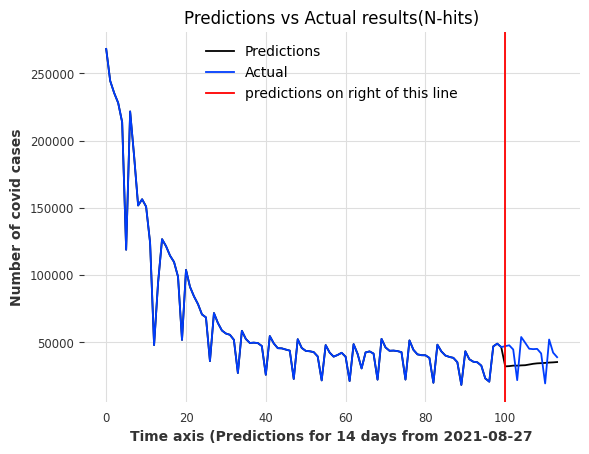

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results(N-hits)")
plt.plot(append(df_total[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df_total[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(actual.reshape(-1))

[47165. 47824. 44686. 21877. 53981. 49711. 45260. 44952. 45153. 41752.
 19452. 52115. 42355. 38973.]


In [ ]:
print(predictions.reshape(-1))

[32147.70922419 32324.31433243 32698.85209306 32680.1119458
 32880.48510213 33004.02360659 33518.76281849 34051.45525271
 34387.17720941 34548.19012495 34716.02136054 34975.77296188
 35127.11200217 35360.06911602]
